<center> <h1>Tweet sentiment analysis</h1> </center>

<h4> Aditya Radjou </h4>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
import nltk
nltk.download("stopwords")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from nltk.corpus import stopwords

from transformers import BertTokenizerFast
from transformers import TFBertModel
import tensorflow as tf
from tensorflow import keras

from imblearn.over_sampling import RandomOverSampler

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, confusion_matrix

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Twitter Sentiment Analysis/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Twitter Sentiment Analysis/test.csv')

df.drop('selected_text',axis=1,inplace=True)
test_df.drop('selected_text',axis=1,inplace=True)

<h2> 1. Data Analysis </h2>

In [5]:
df

,textID,text,sentiment
0,28ac06f416,good luck with your auction,positive
1,92098cf9a7,Hmm..You can`t judge a book by looking at its ...,neutral
2,7858ff28f2,"Hello, yourself. Enjoy London. Watch out for ...",negative
3,b0c9c67f32,We can`t even call you from belgium sucks,negative
4,7b36e9e7a5,not so good mood..,negative
...,...,...,...
24727,678b9c2121,Getting closer to logging in. My left hand is ...,negative
24728,352db9421b,I`m drawning in emails,neutral
24729,5451990147,Oh Duh....I see that now .....thank you....,positive
24730,e57b265e61,"my internet in like 9th grade was so fast, it...",negative


In [6]:
test_df

,textID,text
0,102f98e5e2,Happy Mother`s Day hahaha
1,033b399113,"Sorry for the triple twitter post, was having ..."
2,c125e29be2,thats much better than the flu syndrome!
3,b91e2b0679,Aww I have a tummy ache
4,1a46141274,hey chocolate chips is good. i want a snack ...
...,...,...
2743,0bfb1006b9,Is also having a lonely night.... Wishing she ...
2744,f1df499466,o ok..im jealous..i wish I was in bed
2745,de4da367a4,**** your in trouble now why don`t you try w...
2746,07a8ec4593,HAPPY MOTHER DAY FOR ALL THE STRONG HARD WORKI...


<h4> Data distribution </h4>

[Text(0.5, 1.0, 'Data distribution')]

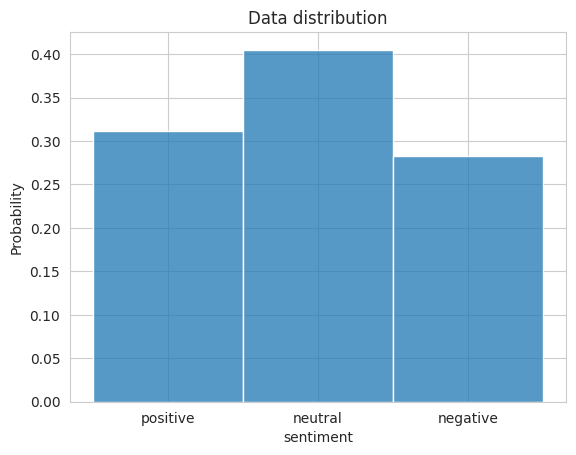

In [7]:
plot = sns.histplot(df['sentiment'],stat="probability")
plot.set(title="Data distribution")

<h4> Distribution of the length of the tweets </h4>

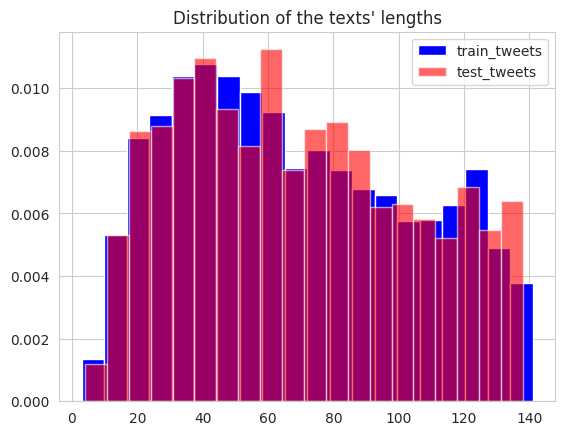

In [8]:
length_train=df['text'].str.len()
length_test=test_df['text'].str.len()
plt.hist(length_train, bins=20, density=True,color="blue", label="train_tweets")
plt.hist(length_test, bins=20, density=True,alpha=0.6, color="red",label="test_tweets")
plt.title("Distribution of the texts' lengths")
plt.legend()
plt.show()

<h2> 2. Data preprocessing </h2>

In [9]:
# we create a validation dataset from the training data
#train_df, val_df = train_test_split(df, test_size=0.1, random_state=0)

In [10]:
#converting the labels to numbers

target_conversion = {
    'neutral': 0,
    'positive': 1,
    'negative': -1
}
df['target'] = df['sentiment'].map(target_conversion)

In [11]:
df.head()

,textID,text,sentiment,target
0,28ac06f416,good luck with your auction,positive,1
1,92098cf9a7,Hmm..You can`t judge a book by looking at its ...,neutral,0
2,7858ff28f2,"Hello, yourself. Enjoy London. Watch out for ...",negative,-1
3,b0c9c67f32,We can`t even call you from belgium sucks,negative,-1
4,7b36e9e7a5,not so good mood..,negative,-1


In [12]:
df['text'] = df['text'].str.lower()
test_df['text'] = test_df['text'].str.lower()

df['text'] = df['text'].str.replace("#", " ") #remove hashtags
test_df['text'] = test_df['text'].str.replace("#", " ") #remove hashtags

apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}

In [13]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word in dictionary:
            if word in text.split():
                text = text.replace(word, dictionary[word])
    return text

In [14]:
for dict in [apostrophe_dict,short_word_dict,emoticon_dict]:
    for data in [df,test_df]:
        data['text'] = data['text'].apply(lambda x: lookup_dict(x,dict))

In [15]:
stop_words = set(stopwords.words("english"))
for data in [df,test_df]:
    data['text'] = data['text'].apply(lambda x : " ".join(word for word in x.split() if word not in stop_words ))

<h2> 3. Predict sentiment </h2>

In [16]:
# we create a validation dataset from the training data
train_df, val_df = train_test_split(df, test_size=0.1, random_state=0)

<h3> 3.1 TextBlob </h3>

In [17]:
from textblob import TextBlob

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

tb_val = val_df
tb_val["polarity"] = tb_val['text'].apply(getPolarity)

def getAnalysis(score):
    if score<0:
        return(-1)
    if score>0:
        return(1)
    return(0)

y_pred = tb_val["polarity"].apply(getAnalysis)

fbeta = fbeta_score(tb_val['target'].values, y_pred, average='macro', beta=1.0)
print('The F-1 score is:', round(fbeta,2))

The F-1 score is: 0.59


<h3> 3.2 VADER </h3>

In [18]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [19]:
sid = SentimentIntensityAnalyzer()
#Examples:
for doc in val_df['text'].iloc[:5].values:
    print(doc)
    print(sid.polarity_scores(doc))

couple days?! sheeeeit. wish there. something cafe claude me.
{'neg': 0.0, 'neu': 0.728, 'pos': 0.272, 'compound': 0.4574}
didn`t make challenge
{'neg': 0.0, 'neu': 0.606, 'pos': 0.394, 'compound': 0.0772}
@_laertesgirl ohh course. stop though, end dream. john woodvine & zoe thorne, ones signed programme
{'neg': 0.136, 'neu': 0.741, 'pos': 0.123, 'compound': -0.0516}
happy mother`s day mom. love always
{'neg': 0.0, 'neu': 0.336, 'pos': 0.664, 'compound': 0.836}
i`m saddest right now. lost mobile phone earphones. waz feels little incomplete feel
{'neg': 0.364, 'neu': 0.636, 'pos': 0.0, 'compound': -0.743}


In [20]:
def vader_predict(x):
    prediction = sid.polarity_scores(x)
    prediction_list = [
        (1, prediction['pos']),
        (-1, prediction['neg']),
        (0, prediction['neu'])
    ]
    label = sorted(prediction_list, key=lambda x: x[1], reverse=True)[0][0]
    return label

In [21]:
predictions_vader = val_df['text'].apply(vader_predict)

In [22]:
fbeta = fbeta_score(val_df['target'].values, predictions_vader, average='macro', beta=1.0)
print('The F-1 score is:', round(fbeta,2))

The F-1 score is: 0.48


<h3> 3.3 Naive Bayes classifier </h3>

We are using the Bag-of-Words method for feature extraction

In [23]:
count_vect = CountVectorizer()

In [24]:
X_train_counts = count_vect.fit_transform(list(train_df['text'].values))
X_val_counts = count_vect.transform(list(val_df['text'].values))
X_test_counts = count_vect.transform(list(test_df['text'].values))

In [25]:
print('Train feature shape:', X_train_counts.shape)
print('Train feature shape:', X_val_counts.shape)
print('Test feature shape:', X_test_counts.shape)

Train feature shape: (22258, 23611)
Train feature shape: (2474, 23611)
Test feature shape: (2748, 23611)


In [26]:
clf = MultinomialNB().fit(X_train_counts, train_df['target'])

In [27]:
val_predictions_nb = clf.predict(X_val_counts)

In [28]:
fbeta = fbeta_score(val_df['target'].values, val_predictions_nb, average='macro', beta=1.0)
print('The F-1 score is:', round(fbeta,2))

The F-1 score is: 0.65


<Axes: >

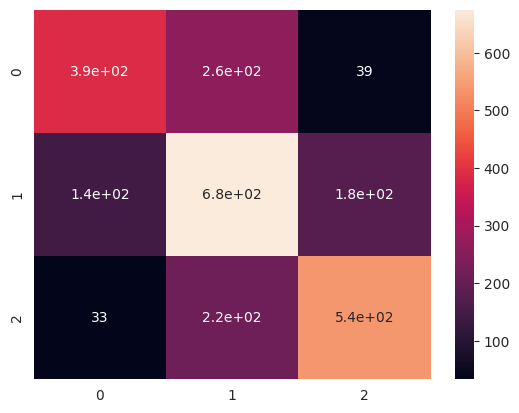

In [29]:
cm = confusion_matrix(val_df['target'].values, val_predictions_nb)
sns.heatmap(cm, annot=True)

<h3> 3.4 BERT Model </h3>

In [30]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text']).reshape(-1, 1), np.array(df['sentiment']).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'sentiment'])

In [31]:
X = train_os['text'].values
y = train_os['sentiment'].values

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, stratify = y)
X_test = test_df['text'].values

In [33]:
ohe = preprocessing.OneHotEncoder()
#y = ohe.fit_transform(np.array(y).reshape(-1, 1)).toarray()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.transform(np.array(y_valid).reshape(-1, 1)).toarray()

In [34]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [35]:
token_lens = []

for txt in X_train:
    tokens = tokenizer.encode(txt, max_length = 128, truncation = True)
    token_lens.append(len(tokens))
    
max_len = np.max(token_lens)

print(f"MAX TOKENIZED SENTENCE LENGTH in train set: {max_len}")

token_lens_test = []

for txt in X_test:
    tokens = tokenizer.encode(txt, max_length = 128, truncation = True)
    token_lens_test.append(len(tokens))
    
max_len = np.max(token_lens_test)

print(f"MAX TOKENIZED SENTENCE LENGTH in test set: {max_len}")

MAX TOKENIZED SENTENCE LENGTH in train set: 109
MAX TOKENIZED SENTENCE LENGTH in test set: 59


In [36]:
MAX_LEN = 128

In [37]:
def tokenize(data,max_len = MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens = True,
            max_length = MAX_LEN,
            padding = 'max_length',
            return_attention_mask = True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

In [38]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [39]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [40]:
def create_model(bert_model, max_len = MAX_LEN):
    
    opt = tf.keras.optimizers.legacy.Adam(learning_rate = 1e-5, decay = 1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape = (max_len, ), dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len, ), dtype = 'int32')
    embeddings = bert_model([input_ids, attention_masks])[1]
    #embeddings = bert_model([input_ids, attention_masks])[0]
    #embeddings = tf.keras.layers.Dense(32, activation = "relu")(embeddings)
    output = tf.keras.layers.Dense(3, activation = "softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
    model.compile(opt, loss = loss, metrics = accuracy)
    
    return model

In [41]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [42]:
history_bert = model.fit([train_input_ids, train_attention_masks], y_train, validation_data = ([val_input_ids, val_attention_masks], y_valid), epochs = 6, batch_size = 16)

Epoch 1/6
1691/1691 [==============================] - 738s 426ms/step - loss: 0.6352 - categorical_accuracy: 0.7364 - val_loss: 0.5481 - val_categorical_accuracy: 0.7864
Epoch 2/6
1691/1691 [==============================] - 719s 425ms/step - loss: 0.4576 - categorical_accuracy: 0.8230 - val_loss: 0.5037 - val_categorical_accuracy: 0.8127
Epoch 3/6
1691/1691 [==============================] - 732s 433ms/step - loss: 0.3305 - categorical_accuracy: 0.8781 - val_loss: 0.5349 - val_categorical_accuracy: 0.8097
Epoch 4/6
1691/1691 [==============================] - 724s 428ms/step - loss: 0.2192 - categorical_accuracy: 0.9194 - val_loss: 0.6097 - val_categorical_accuracy: 0.8190
Epoch 5/6
1691/1691 [==============================] - 718s 425ms/step - loss: 0.1434 - categorical_accuracy: 0.9499 - val_loss: 0.6448 - val_categorical_accuracy: 0.8263
Epoch 6/6
1691/1691 [==============================] - 718s 425ms/step - loss: 0.0972 - categorical_accuracy: 0.9671 - val_loss: 0.7498 - val_cat

In [43]:
result_val_bert = model.predict([val_input_ids, val_attention_masks])

94/94 [==============================] - 28s 270ms/step


In [44]:
y_pred_val_bert =  np.zeros_like(result_val_bert)
y_pred_val_bert[np.arange(len(y_pred_val_bert)), result_val_bert.argmax(1)] = 1

In [45]:
comparison_df = pd.DataFrame()
comparison_df["true"] = ohe.inverse_transform(y_valid).reshape(-1, )
comparison_df['predict'] = ohe.inverse_transform(y_pred_val_bert).reshape(-1, )

fbeta = fbeta_score(comparison_df['true'].values, comparison_df['predict'].values, average='macro', beta=1.0)
print('The F-1 score is:', round(fbeta,2))

The F-1 score is: 0.83


<h3> 4. Observations on test set </h3>

In [46]:
test_df

,textID,text
0,102f98e5e2,happy mother`s day hahaha
1,033b399113,"sorry triple twitter post, trouble w/stocktwit..."
2,c125e29be2,thats much better flu syndrome!
3,b91e2b0679,aww tummy ache
4,1a46141274,hey chocolate chips good. want snack i`m snacks.
...,...,...
2743,0bfb1006b9,also lonely night.... wishing could go audun`s...
2744,f1df499466,ok..im jealous..i wish bed
2745,de4da367a4,**** trouble don`t try one companys buys house
2746,07a8ec4593,"happy mother day strong hard working mothers, ..."


In [47]:
pred_sentiment = model.predict([test_input_ids, test_attention_masks])
y_pred_test_bert = np.zeros_like(pred_sentiment)
y_pred_test_bert[np.arange(len(y_pred_test_bert)), pred_sentiment.argmax(1)] = 1

test_df["predicted_sentiment"] = ohe.inverse_transform(y_pred_test_bert).reshape(-1, )
test_df.head(10)

86/86 [==============================] - 24s 278ms/step


,textID,text,predicted_sentiment
0,102f98e5e2,happy mother`s day hahaha,positive
1,033b399113,"sorry triple twitter post, trouble w/stocktwit...",negative
2,c125e29be2,thats much better flu syndrome!,neutral
3,b91e2b0679,aww tummy ache,negative
4,1a46141274,hey chocolate chips good. want snack i`m snacks.,positive
5,45208fede8,_honi might cute little picture book called 't...,neutral
6,12b042da32,- produce/direct/film/edit... write... coordin...,neutral
7,23dda65ff8,"love fly me, live chats don`t like sick.",neutral
8,636d7728af,"caww sounds good, hope you`re right",positive
9,a511a1b75c,think need new friends,neutral
